# Сравнение алгоритмов SVM
### цель: смоделировать данные 20newsgroup с помощью алгоритма linear scv

#### импортируем библиотеки для обработки текста, для моделирования, для оптимизации с помощью hyperopt

In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.datasets import fetch_20newsgroups

In [2]:
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

In [3]:
from hyperopt import hp
from hyperopt import tpe
from hyperopt import rand
from hyperopt import Trials
from hyperopt.fmin import fmin

In [4]:
import pickle

In [5]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.svm import NuSVC

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
train = fetch_20newsgroups(subset='train')
test = fetch_20newsgroups(subset='test')

### смотрим значения целевой переменной

In [5]:
print(train['target_names'])

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [72]:
print(train['target'][17])

7


### выводим пример

In [71]:
print(train['data'][17])

From: CPKJP@vm.cc.latech.edu (Kevin Parker)
Subject: Insurance Rates on Performance Cars SUMMARY
Organization: Louisiana Tech University
Lines: 244
NNTP-Posting-Host: vm.cc.latech.edu
X-Newsreader: NNR/VM S_1.3.2

     I recently posted an article asking what kind of rates single, male
drivers under 25 yrs old were paying on performance cars. Here's a summary of
the replies I received.
 
 
 
 
-------------------------------------------------------------------------------
 
I'm not under 25 anymore (but is 27 close enough).
 
1992 Dodge Stealth RT/Twin Turbo (300hp model).
No tickets, no accidents, own a house, have taken defensive driving 1,
airbag, abs, security alarm, single.
 
$1500/year  $500 decut. State Farm Insurance (this includes the additional $100
for the $1,000,000 umbrella policy over my car and house)  The base
policy is the standard $100,000 - $100,000 - $300,000 policy required in DE.
 
After 2nd defensive driving course it will be 5% less.
 
I bought the car in Septem

In [8]:
X_train, y_train = train.data, train.target
X_test, y_test = test.data, test.target

In [7]:
# функция удаления url адрессов
def del_links(chat_string):
    pattern = '(?:https?:\/\/)?(?:[\w\.]+)\.(?:[a-z]{2,6}\.?)(?:\/[\w\.]*)*\/?'
    return re.sub(pattern, ' ', chat_string)
# функция удаления стоп-слов
def clean_stopwords(text):
    stop_words = stopwords.words('english')
    text = [word for word in text.split() if word not in stop_words]
    return ' '.join(text)

# функция удалениы эмодзи 
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

bad_words = ['aaa', 'aaaa', 'aaaaaaaaaaaa',
             'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaauuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuugggggggggggggggg',
             'aaaaagggghhhh', 'aaaarrgghhhh', 'aaah', 'aaahhhh', 'aaai',
             'aab', 'aacc', 'aachen', 'aaef', 'aah', 'aaj',
             'aalac', 'aalborg', 'aalm', 'aamazing', 'aamir',
             'aammmaaaazzzzzziinnnnggggg', 'aams', 'aan', 'aanbieden',
             'aanerud', 'aangeboden', 'aangegeven', 'aangezien',
             'aanp', 'aantal', 'aao', 'aaos', 'aap', 'aaph', 'aaplay',
             'aar', 'aargh', 'aarghhhh', 'aarhus', 'aario',
             'aarnet', 'aaron', 'aaronson', 'aarp', 'aarseth', 'aarskog',
             'aart', 'aas', 'aasked', 'aatchoo', 'aau',
             'aauwpiugyv', 'aav', 'aavb', 'aavso', 'aaw', 'aax', 'aayau', 'aazaadee',
             'aazo', 'aba', 'ababs', 'abacus', 'abad',
             'abaihm', 'abba', 'abbott', 'abbrev', 'abc',
             'abcdef','abcdefghijklmnopqrstuvwxyz',
             'abcpv', 'abd', 'abe', 'abed', 'abedk', 'abeel',
             'abeit', 'abekas', 'abel', 'aben', 'abeoz', 'abfb', 'abfdefghiijklmmnohpp',
             'abg', 'abrg', 'abri', 'acc', 'aef', 'aec', 'aeo']
#функция удаления несуществующих слов
def remove_nonexsistent(text):
    words = [el for el in text.split() if el not in bad_words]
    return ' '.join(words)
    


def lemming(text):
    lemmatizer = WordNetLemmatizer()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    text = [lemmatizer.lemmatize(w[0], tag_dict.get(w[1][0], wordnet.NOUN)) for w in nltk.pos_tag(text.split())]
    return ' '.join(text)

# функция очистки текста
def clean_text(text):
    text = remove_nonexsistent(text)
    #удалим эмодзи 
    text = remove_emoji(text)
    #удалим url адресса
    text = del_links(text)
    # удалим все почтовые адреса
    text = re.sub(r'([\w0-9-._]+@[\w0-9-.]+[\w0-9]{2,3})', ' ', text)
    # удалим все символы за исключением букв
    text = re.sub(r'[^\w\s]+|[\d]+|[\_]', r' ', text)
    # осуществим лемминг
    text = lemming(text)
    # удалим слова длины <3
    text = ' '.join([word for word in text.split() if len(word)>2])
    return text

In [11]:
X_train = [clean_text(el) for el in X_train]

In [12]:
X_test = [clean_text(el) for el in X_test]

### сохраняем очищенные данные в файл (слишком много по времени идет очистка)

In [14]:
with open('X_train.pkl', 'wb') as output:
    pickle.dump(X_train, output, pickle.HIGHEST_PROTOCOL)

In [15]:
with open('X_test.pkl', 'wb') as output:
    pickle.dump(X_test, output, pickle.HIGHEST_PROTOCOL)

In [8]:
#with open('X_train.pkl', 'rb') as output:
#    X_train = pickle.load(output)
#with open('X_test.pkl', 'rb') as output:
#    X_test = pickle.load(output)
#    
#y_train = train.target
#y_test = test.target

In [8]:
X_test[0]

'From NEIL GANDLER Subject Need info Bonneville Organization University Buffalo Lines News Software VAX VMS VNEWS Nntp Posting Host little confuse all the model the bonnevilles have hear the LSE SSE SSEI Could someone tell the difference far feature performance also curious know what the book value for prefereably the model And how much less than book value can you usually get them for other word how much they demand this time year have hear that the mid spring early summer the best time buy Neil Gandler'

### Векторизируем тексты через tf-idf

In [9]:
vect = TfidfVectorizer(lowercase=True, stop_words='english').fit(X_train)

In [10]:
X_train = vect.transform(X_train)

In [11]:
X_test = vect.transform(X_test)

In [12]:
X_train

<11314x78669 sparse matrix of type '<class 'numpy.float64'>'
	with 1022666 stored elements in Compressed Sparse Row format>

### моделируем данные с помощью LinearSVC

In [13]:
model = LinearSVC().fit(X_train, y_train)

In [17]:
model.score(X_test, y_test)

0.8459904407859798

In [18]:
with open('model_Linear_SVC.pkl', 'wb') as output:
    pickle.dump(model, output, pickle.HIGHEST_PROTOCOL)

### оптимизируем алгоритм с помощью hyperopt

In [14]:
#domain space
domain_linear_svc = {
    'C': hp.uniform('C', 1, 20),
    'penalty': hp.choice('penalty', ['l1', 'l2']),
    'max_iter': hp.uniform('max_iter', 1000, 1100)
}

In [15]:
#objective function
def objective_linear_svc(params):
    linear_svc = LinearSVC(**params)
    scr = cross_val_score(linear_svc, X_train, y_train, n_jobs=-1, cv=3).mean()
    return -scr

In [16]:
trl = Trials()
best = fmin(fn=objective_linear_svc, space=domain_linear_svc, algo=tpe.suggest, max_evals=6, trials=trl)
print('best C, penalty, max_iter: ', end=' ')
print(best)

100%|██████████| 6/6 [00:17<00:00,  2.89s/it, best loss: nan]
best C, penalty, max_iter:  {'C': 6.0776180852830795, 'max_iter': 1084.8004338184767, 'penalty': 1}


In [18]:
hyper_linear_svc = LinearSVC(C=6.077, max_iter=1085, penalty='l2').fit(X_train, y_train)

In [19]:
hyper_linear_svc.score(X_test, y_test)

0.8385554965480616

### сохраняем оптимизированную модель в файл

In [20]:
with open('hyper_linear_SVC.pkl', 'wb') as output:
    pickle.dump(hyper_linear_svc, output, pickle.HIGHEST_PROTOCOL)

### моделируем данные с помощью SVC poly kernel

In [17]:
model = SVC(kernel='poly', degree=2).fit(X_train, y_train)

In [18]:
model.score(X_test, y_test)

0.7603558151885289

### оптимизируем модель с помощью hyperopt

In [21]:
#domain space
domain_svc = {
    'C': hp.uniform('C', 1, 100)
}

In [22]:
#objective function
def objective_poly_svc(params):
    svc = SVC(kernel='poly', degree=2)
    scr = cross_val_score(svc, X_train, y_train, cv=3, n_jobs=-1).mean()
    return -scr

In [25]:
trl = Trials()
best = fmin(fn=objective_poly_svc, space=domain_svc, trials=trl, algo=tpe.suggest, max_evals=10)
print('best C:', end=' ')
print(best)

100%|██████████| 10/10 [17:47<00:00, 106.75s/it, best loss: -0.8483295009007646]
best C: {'C': 75.0696292790428}


In [26]:
hyper_poly_svc = SVC(kernel='poly', degree=2, C=75.0696292790428).fit(X_train, y_train)

In [27]:
hyper_poly_svc.score(X_test, y_test)

0.7664630908125332

### Сохраняем модели в файл

In [30]:
with open('hyper_SVC_poly_degree_2.pkl', 'wb') as output:
    pickle.dump(hyper_poly_svc, output, pickle.HIGHEST_PROTOCOL)

In [29]:
with open('model_SVC_poly_degree_2.pkl', 'wb') as output:
    pickle.dump(model, output, pickle.HIGHEST_PROTOCOL)

### моделируем данные с помощью SVC sigmoid kernel

In [31]:
model = SVC(kernel='sigmoid').fit(X_train, y_train)

In [32]:
model.score(X_test, y_test)

0.8284652150823154

### оптимизируем с помощью hyperopt

In [36]:
#domain space
domain_svc = {
    'C': hp.uniform('C', 1, 100),
    'max_iter': hp.uniform('max_iter', 1000, 1100)
}

In [35]:
#objective function
def objective_sigmoid_svc(params):
    svc = SVC(kernel='sigmoid')
    scr = cross_val_score(svc, X_train, y_train, cv=3, n_jobs=-1).mean()
    return -scr

In [37]:
trl = Trials()
best = fmin(fn=objective_sigmoid_svc, space=domain_svc, trials=trl, algo=rand.suggest, max_evals=10)
print('best:', end=' ')
print(best)

100%|██████████| 10/10 [09:54<00:00, 59.40s/it, best loss: -0.9007426679711091]
best C: {'C': 5.929299500939039, 'max_iter': 1043.948773972298}


In [41]:
hyper_sigmoid = SVC(kernel='sigmoid', C=5.929299500939039, max_iter=1044).fit(X_train, y_train)

/Users/sashaperetsiagin/anaconda3/envs/classic/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1044).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [42]:
hyper_sigmoid.score(X_test, y_test)

0.8248805098247477

### сохраняем модели в файл

In [38]:
with open('model_SVC_sigmoid.pkl', 'wb') as output:
    pickle.dump(model, output, pickle.HIGHEST_PROTOCOL)

In [43]:
with open('hyper_SVC_sigmoid.pkl', 'wb') as output:
    pickle.dump(hyper_sigmoid, output, pickle.HIGHEST_PROTOCOL)

### моделируем данные с помощью SVC rbf kernel

In [44]:
model = SVC().fit(X_train, y_train)

In [45]:
model.score(X_test, y_test)

0.821959638874137

### оптимизируем с помощью hyperopt

In [47]:
#domain space
domain_svc = {
    'C': hp.uniform('C', 1, 100),
    'max_iter': hp.uniform('max_iter', 1000, 1100)
}

In [49]:
#objective function
def objective_rbf_svc(params):
    svc = SVC()
    scr = cross_val_score(svc, X_train, y_train, cv=3, n_jobs=-1).mean()
    return -scr

In [50]:
trl = Trials()
best = fmin(fn=objective_rbf_svc, space=domain_svc, trials=trl, algo=rand.suggest, max_evals=10)
print('best:', end=' ')
print(best)

100%|██████████| 10/10 [17:30<00:00, 105.05s/it, best loss: -0.8910205828390821]
best: {'C': 8.485320006385479, 'max_iter': 1034.8041954505939}


In [51]:
hyper_rbf = SVC(C=8.485320006385479, max_iter=1035).fit(X_train, y_train)

/Users/sashaperetsiagin/anaconda3/envs/classic/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1035).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [52]:
hyper_rbf.score(X_test, y_test)

0.8271375464684015

### сохраняем модели в файл

In [46]:
with open('model_rbf_kernel.pkl', 'wb') as output:
    pickle.dump(model, output, pickle.HIGHEST_PROTOCOL)

In [53]:
with open('hyper_rbf_kernel.pkl', 'wb') as output:
    pickle.dump(hyper_rbf, output, pickle.HIGHEST_PROTOCOL)

In [65]:
print('Minimum loss:{:.4f}'.format(trl.best_trial['result']['loss']))

Minimum loss:-0.8910


### выведем результаты hyperopt модели svc rbf kernel

In [66]:
trl.results

[{'loss': -0.8910205828390821, 'status': 'ok'},
 {'loss': -0.8910205828390821, 'status': 'ok'},
 {'loss': -0.8910205828390821, 'status': 'ok'},
 {'loss': -0.8910205828390821, 'status': 'ok'},
 {'loss': -0.8910205828390821, 'status': 'ok'},
 {'loss': -0.8910205828390821, 'status': 'ok'},
 {'loss': -0.8910205828390821, 'status': 'ok'},
 {'loss': -0.8910205828390821, 'status': 'ok'},
 {'loss': -0.8910205828390821, 'status': 'ok'},
 {'loss': -0.8910205828390821, 'status': 'ok'}]

In [68]:
trl.idxs_vals

({'C': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
  'max_iter': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]},
 {'C': [8.485320006385479,
   95.7958812824337,
   79.70668178881334,
   70.57025288860919,
   17.85357218710679,
   10.342067577520401,
   83.29726103973543,
   94.25104313026078,
   89.48999848721958,
   91.69160438026877],
  'max_iter': [1034.8041954505939,
   1069.8375786803094,
   1040.368006042215,
   1091.7266185248307,
   1001.700201873029,
   1062.781817012842,
   1096.0325035892527,
   1000.4437622922317,
   1062.2629187775974,
   1098.4389938623224]})

In [82]:
tpe_results = pd.DataFrame({'loss': [x['loss'] for x in trl.results],
                            'iteration': trl.idxs_vals[0]['C'],
                            'C': trl.idxs_vals[1]['C']})

In [88]:
tpe_results.head()

,loss,iteration,C
0,-0.891021,0,8.485320
1,-0.891021,1,95.795881
2,-0.891021,2,79.706682
3,-0.891021,3,70.570253
4,-0.891021,4,17.853572


### выводим график зависимости кол-во итераций от значения С: был использован алгоритм rand.suggest, поэтому сходимости в кластеры нет

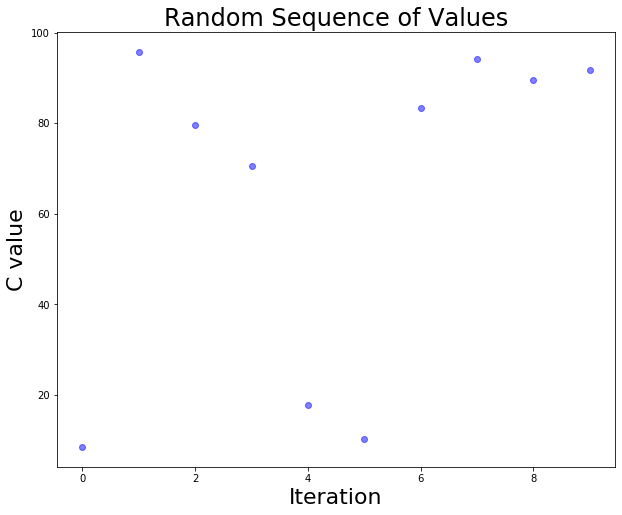

In [91]:
plt.figure(figsize = (10, 8));
plt.plot(tpe_results['iteration'], tpe_results['C'],  'bo', alpha = 0.5);
plt.xlabel('Iteration', size = 22);
plt.ylabel('C value', size = 22);
plt.title('Random Sequence of Values', size = 24);
plt.savefig('random_sequence.png')

### Вывод: с помощью обычной линейной модели LinearSVC мы предсказываем относительно неплохой результат (около 83), оптимизация гиперпараметров с помощью hyperopt не сильно повлияла на результат